In [ ]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

# Translation

In [2]:
#@title
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/1JvfrvZgi6c?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Translation converts a sequence of text from one language to another. It is one of several tasks you can formulate as a sequence-to-sequence problem, a powerful framework for returning some output from an input, like translation or summarization. Translation systems are commonly used for translation between different language texts, but it can also be used for speech or some combination in between like text-to-speech or speech-to-text.

This guide will show you how to:

1. Finetune [T5](https://huggingface.co/t5-small) on the English-French subset of the [OPUS Books](https://huggingface.co/datasets/opus_books) dataset to translate English text to French.
2. Use your finetuned model for inference.

<Tip>
The task illustrated in this tutorial is supported by the following model architectures:

<!--This tip is automatically generated by `make fix-copies`, do not fill manually!-->

[BART](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/bart), [BigBird-Pegasus](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/bigbird_pegasus), [Blenderbot](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/blenderbot), [BlenderbotSmall](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/blenderbot-small), [Encoder decoder](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/encoder-decoder), [FairSeq Machine-Translation](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/fsmt), [GPTSAN-japanese](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/gptsan-japanese), [LED](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/led), [LongT5](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/longt5), [M2M100](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/m2m_100), [Marian](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/marian), [mBART](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/mbart), [MT5](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/mt5), [MVP](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/mvp), [NLLB](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/nllb), [NLLB-MOE](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/nllb-moe), [Pegasus](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/pegasus), [PEGASUS-X](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/pegasus_x), [PLBart](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/plbart), [ProphetNet](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/prophetnet), [SwitchTransformers](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/switch_transformers), [T5](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/t5), [XLM-ProphetNet](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/xlm-prophetnet)

<!--End of the generated tip-->

</Tip>

Before you begin, make sure you have all the necessary libraries installed:

```bash
pip install transformers datasets evaluate sacrebleu
```

We encourage you to login to your Hugging Face account so you can upload and share your model with the community. When prompted, enter your token to login:

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## Load OPUS Books dataset

Start by loading the English-French subset of the [OPUS Books](https://huggingface.co/datasets/opus_books) dataset from the 🤗 Datasets library:

In [25]:
from datasets import load_dataset

books = load_dataset("opus_books", "de-en")

Split the dataset into a train and test set with the [train_test_split](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.train_test_split) method:

In [27]:
books = books["train"].train_test_split(test_size=0.2)

Then take a look at an example:

In [50]:
books["train"][0]

{'id': '8087',
 'translation': {'de': 'Der Wirt war ein anständig aussehender Mann in mittleren Jahren.',
  'en': 'The host was a respectable-looking, middle-aged man.'}}

`translation`: an English and French translation of the text.

## Preprocess

The next step is to load a T5 tokenizer to process the English-French language pairs:
다음 단계는 영어-프랑스어 쌍을 처리하기 위해 T5 토큰화기를 로드하는 것입니다:

체크포인트(Checkpoint)란 모델 학습 과정 중 특정 시점의 모델의 가중치와 파라미터를 저장한 상태이다. 이는 일종의 저장 상태로, 학습 중인 모델의 진행 상황을 특정 지점에서 보존하는 데 사용된다.

from_pretrained 메소드를 이용하여 지정한 체크포인트의 사전 훈련된 토크나이저를 불러와 tokenizer라는 변수에 저장하는 코드입니다. 이때, from_pretrained 메소드는 인터넷에서 해당 체크포인트의 토크나이저를 다운로드하고, 적절한 토크나이저 클래스의 인스턴스를 생성합니다.
토크나이저는 텍스트 데이터를 모델이 처리할 수 있는 형식, 즉 토큰으로 변환하는 역할을 합니다. 이는 자연어 처리 모델의 입력을 준비하는 데 필수적인 과정입니다. 따라서 이 코드는 T5 모델을 사용하기 위한 토크나이저를 준비하는 과정을 보여주고 있습니다.

In [33]:
from transformers import AutoTokenizer
checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

The preprocessing function you want to create needs to:

1. Prefix the input with a prompt so T5 knows this is a translation task. Some models capable of multiple NLP tasks require prompting for specific tasks.
2. Tokenize the input (English) and target (French) separately because you can't tokenize French text with a tokenizer pretrained on an English vocabulary.
3. Truncate sequences to be no longer than the maximum length set by the `max_length` parameter.

생성하려는 전처리 기능은 다음과 같아야 합니다:

1. 입력 앞에 프롬프트를 붙여 T5가 이것이 번역 작업임을 알 수 있도록 합니다. 여러 NLP 작업을 수행할 수 있는 일부 모델은 특정 작업에 대한 프롬프트가 필요합니다.
2. 영어 어휘에 대해 사전 학습된 토큰화 도구로는 프랑스어 텍스트를 토큰화할 수 없으므로 입력(영어)과 대상(프랑스어)을 별도로 토큰화합니다.
3. 'max_length' 매개변수로 설정한 최대 길이보다 길지 않도록 시퀀스를 잘라냅니다.

In [34]:
source_lang = "de"
target_lang = "en"
prefix = "translate German to English: "


def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

To apply the preprocessing function over the entire dataset, use 🤗 Datasets [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map) method. You can speed up the `map` function by setting `batched=True` to process multiple elements of the dataset at once:

전체 데이터 집합에 전처리 기능을 적용하려면 🤗 데이터 집합 [맵]을 사용합니다.
`batched=True`를 설정하여 데이터 세트의 여러 요소를 한 번에 처리하면 `map` 함수의 속도를 높일 수 있습니다:

In [35]:
tokenized_books = books.map(preprocess_function, batched=True)

Map:   0%|          | 0/41173 [00:00<?, ? examples/s]

Map:   0%|          | 0/10294 [00:00<?, ? examples/s]

In [52]:
books

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 41173
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 10294
    })
})

In [51]:
tokenized_books

DatasetDict({
    train: Dataset({
        features: ['id', 'translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 41173
    })
    test: Dataset({
        features: ['id', 'translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10294
    })
})

Now create a batch of examples using [DataCollatorForSeq2Seq](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DataCollatorForSeq2Seq). It's more efficient to *dynamically pad* the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

이제 [DataCollatorForSeq2Seq](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DataCollatorForSeq2Seq)를 사용해 예제 일괄 처리를 생성합니다. 데이터 정렬 중에 전체 데이터 집합을 최대 길이로 패딩하는 대신 일괄 처리에서 가장 긴 길이로 문장을 *동적으로 패딩*하는 것이 더 효율적입니다.

***

DataCollatorForSeq2Seq는 허깅페이스의 변환기 라이브러리에서 제공하는 클래스입니다. 이 클래스는 시퀀스 학습 모델에 대한 배치 생성 과정을 돕습니다.

동적 패딩(dynamic padding)은 모든 데이터를 최대 길이로 패딩하는 대신, 각 배치에서 가장 긴 문장의 길이로 패딩하는 것을 말합니다. 이렇게 하면 메모리 효율성이 향상되고, 훈련 속도도 빨라집니다.

In [36]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

## Evaluate

Including a metric during training is often helpful for evaluating your model's performance. You can quickly load a evaluation method with the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library. For this task, load the [SacreBLEU](https://huggingface.co/spaces/evaluate-metric/sacrebleu) metric (see the 🤗 Evaluate [quick tour](https://huggingface.co/docs/evaluate/a_quick_tour) to learn more about how to load and compute a metric):

In [ ]:
pip install evaluate

In [13]:
pip install sacrebleu

In [37]:
import evaluate

metric = evaluate.load("sacrebleu")

Then create a function that passes your predictions and labels to [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute) to calculate the SacreBLEU score:

In [38]:
import numpy as np


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

Your `compute_metrics` function is ready to go now, and you'll return to it when you setup your training.

## Train

<Tip>

If you aren't familiar with finetuning a model with the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer), take a look at the basic tutorial [here](https://huggingface.co/docs/transformers/main/en/tasks/../training#train-with-pytorch-trainer)!

</Tip>

You're ready to start training your model now! Load T5 with [AutoModelForSeq2SeqLM](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForSeq2SeqLM):

In [39]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

At this point, only three steps remain:

1. Define your training hyperparameters in [Seq2SeqTrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Seq2SeqTrainingArguments). The only required parameter is `output_dir` which specifies where to save your model. You'll push this model to the Hub by setting `push_to_hub=True` (you need to be signed in to Hugging Face to upload your model). At the end of each epoch, the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) will evaluate the SacreBLEU metric and save the training checkpoint.
2. Pass the training arguments to [Seq2SeqTrainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Seq2SeqTrainer) along with the model, dataset, tokenizer, data collator, and `compute_metrics` function.
3. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

In [ ]:
pip install transformers[torch]

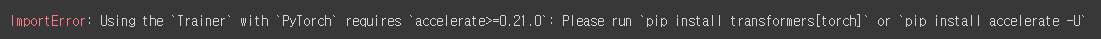

In [ ]:
pip install accelerate -U

In [40]:
training_args = Seq2SeqTrainingArguments(
    output_dir="my_awesome_opus_books_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_books["train"],
    eval_dataset=tokenized_books["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,3.162400,2.855427,3.713300,16.439300
2,3.087000,2.811284,4.001200,16.432800


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


TrainOutput(global_step=5148, training_loss=3.195508985067396, metrics={'train_runtime': 1089.7453, 'train_samples_per_second': 75.564, 'train_steps_per_second': 4.724, 'total_flos': 2405421643038720.0, 'train_loss': 3.195508985067396, 'epoch': 2.0})

In [41]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1708514753.0a0e8ef56fd3.2709.1:   0%|          | 0.00/8.03k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Uiji/my_awesome_opus_books_model/commit/5f9e95cf7ae695fbeb5232cbaf028c803233cdb1', commit_message='End of training', commit_description='', oid='5f9e95cf7ae695fbeb5232cbaf028c803233cdb1', pr_url=None, pr_revision=None, pr_num=None)

<Tip>

For a more in-depth example of how to finetune a model for translation, take a look at the corresponding
[PyTorch notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/translation.ipynb)
or [TensorFlow notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/translation-tf.ipynb).

</Tip>

## Inference

Great, now that you've finetuned a model, you can use it for inference!

Come up with some text you'd like to translate to another language. For T5, you need to prefix your input depending on the task you're working on. For translation from English to French, you should prefix your input as shown below:

In [53]:
text = "translate German to English: Ich würde erstens gar nichts tun, wenn ich im Lotto gewinnen würde.."

The simplest way to try out your finetuned model for inference is to use it in a [pipeline()](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.pipeline). Instantiate a `pipeline` for translation with your model, and pass your text to it:

In [54]:
from transformers import pipeline

translator = pipeline("translation", model="my_awesome_opus_books_model")
translator(text)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/__init__.py:1049: UserWarning: "translation" task was used, instead of "translation_XX_to_YY", defaulting to "translation_en_to_de"
  warnings.warn(


[{'translation_text': 'I would do nothing, if I would win in Lotto..'}]

You can also manually replicate the results of the `pipeline` if you'd like:

Tokenize the text and return the `input_ids` as PyTorch tensors:

In [55]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("my_awesome_opus_books_model")
inputs = tokenizer(text, return_tensors="pt").input_ids

Use the [generate()](https://huggingface.co/docs/transformers/main/en/main_classes/text_generation#transformers.GenerationMixin.generate) method to create the translation. For more details about the different text generation strategies and parameters for controlling generation, check out the [Text Generation](https://huggingface.co/docs/transformers/main/en/tasks/../main_classes/text_generation) API.

In [56]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("my_awesome_opus_books_model")
outputs = model.generate(inputs, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)

Decode the generated token ids back into text:

In [57]:
tokenizer.decode(outputs[0], skip_special_tokens=True)

'It would be hard to turn my heart into a little bit of a bit like a lot of mud.'